##  Load Packages

In [58]:
using DataFrames, StatsPlots, CSV, HTTP
using Distributions, Turing, MCMCChains
using StatsBase:mad

## Load Data

In [2]:
data = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectionsEconomy/data/hibbs.dat"
hibbs = CSV.File(HTTP.get(data).body, delim=" ") |> DataFrame
first(hibbs, 6)

,year,growth,vote,inc_party_candidate,other_candidate
,Int64,Float64,Float64,String,String
1,1952,2.4,44.6,Stevenson,Eisenhower
2,1956,2.89,57.76,Eisenhower,Stevenson
3,1960,0.85,49.91,Nixon,Kennedy
4,1964,4.21,61.34,Johnson,Goldwater
5,1968,3.02,49.6,Humphrey,Nixon
6,1972,3.62,61.79,Nixon,McGovern


## Graphing the bread and peace model

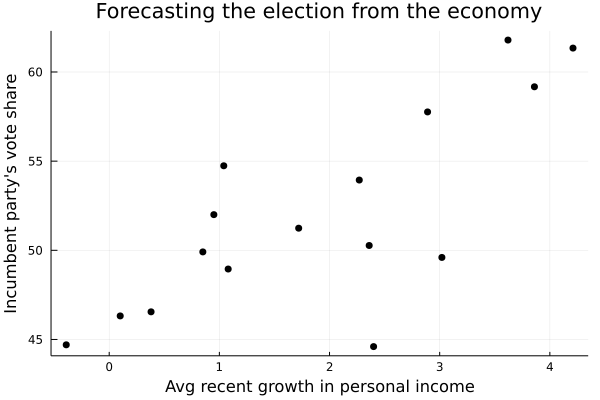

In [20]:
@df hibbs scatter(
    :growth,
    :vote,
    xlabel="Avg recent growth in personal income",
    ylabel="Incumbent party's vote share",
    title="Forecasting the election from the economy",
    color=:black,
    legend=false
)
# TODO: Strings as markers? Can't find functionality in Plots.jl

## Linear Regression

In [37]:
@model function m1(g, v)
    
    # Variance
    σ ~ truncated(Normal(0,100), 0, Inf)
    
    # Linear
    α ~ Normal(0, 100)
    β ~ Normal(0, 100)
    
    μ = α .+ g * β
    v ~ MvNormal(μ, σ)
end;

In [38]:
model = m1(hibbs[:, :growth], hibbs[:, :vote])
chain = sample(model, NUTS(0.65), 4000)
summarystats(chain)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α   46.3254    1.8541     0.0293    0.0431   1622.8684    0.9998    ⋯
           β    3.0524    0.7994     0.0126    0.0192   1563.8356    0.9998    ⋯
           σ    4.1685    0.9107     0.0144    0.0199   1997.2549    0.9998    ⋯
                                                                1 column omitted


## Plot Regression Line

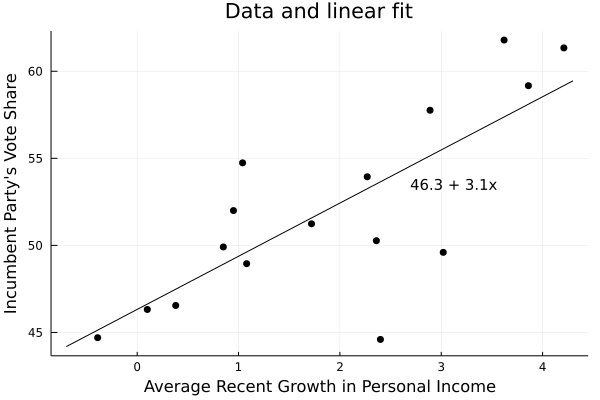

In [39]:
results = get(chain, [:α, :β, :σ]);

@df hibbs scatter(
    :growth,
    :vote,
    xlabel="Average Recent Growth in Personal Income",
    ylabel="Incumbent Party's Vote Share",
    color=:black,
    legend=false,
    title="Data and linear fit"
)

int = mean(results.α)
slope = mean(results.β)
plot!( 
    (x) -> int + slope * x,
    -.7:4.5,
    color=:black
)
annotate!(2.7,53.5, text(string(round(int,digits=1), " + ", round(slope,digits=1), "x"), :left, 10))

In [29]:
?text

search: text Text textwidth TextDisplay @text_str istextmime atexit splitext



```
text(string, args...; kw...)
```

Create a PlotText object wrapping a string with font info, for plot annotations. `args` and `kw` are passed to `font`.


## Plot Prediction Given 2% Growth

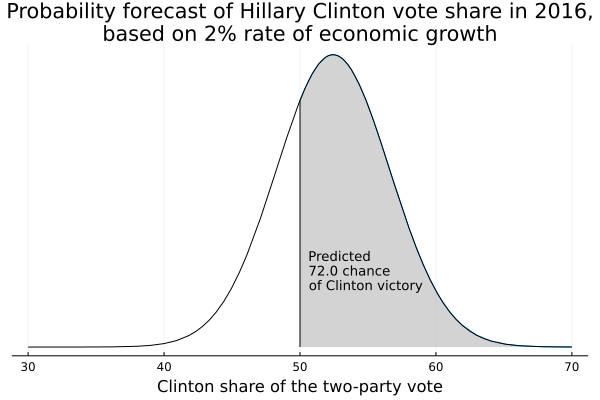

In [41]:
pred_mu = int + slope * 2.0
pred_sigma = mean(results.σ)
victory = round( 100*(cdf(Normal(pred_mu, pred_sigma), Inf) - cdf(Normal(pred_mu, pred_sigma), 50)))

title="Probability forecast of Hillary Clinton vote share in 2016,\nbased on 2% rate of economic growth"
xlabel="Clinton share of the two-party vote"
let n = Normal(pred_mu,pred_sigma), (from,x0,to) = (30,50,70)
    plot(x->pdf(n,x), x0, to, fillrange=0, fill=(0,0.5,"darkgray"),
        legend=false, yaxis=false, yticks=false,
        title=title, xlabel=xlabel
    )
    plot!(x->pdf(n,x), from, to, c="black")
    plot!([x0,x0], [0, pdf(n,x0)], c="black")
    annotate!(50.7, 0.025, text("Predicted\n$victory chance\nof Clinton victory",9, :left))
end


## Plot Data and Linear Fit

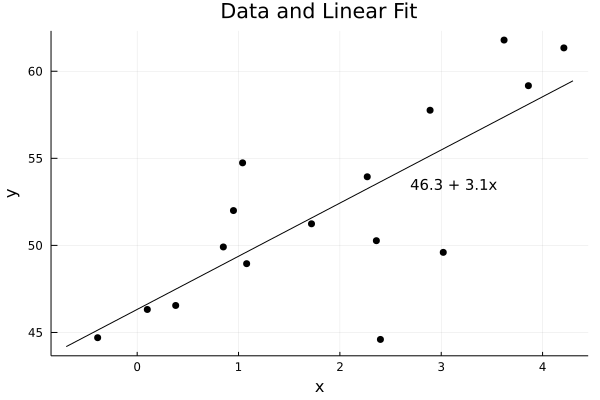

In [45]:
@df hibbs scatter(
    :growth,
    :vote,
    xlabel="x",
    ylabel="y",
    title="Data and Linear Fit",
    color=:black,
    legend=false
)
plot!( 
    (x) -> int + slope * x,
    -.7:4.5,
    color=:black
)
annotate!(2.7,53.5, text(string(round(int,digits=1), " + ", round(slope,digits=1), "x"), :left, 10))

## Plot data and a range of possible linear fits

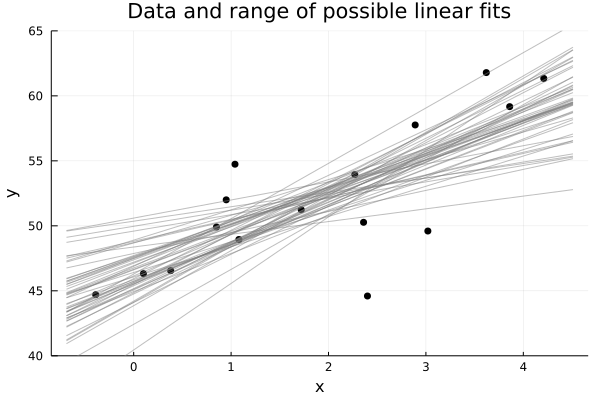

In [46]:
p = @df hibbs scatter(
    :growth,
    :vote,
    xlabel="x",
    ylabel="y",
    label="data",
    title="Data and range of possible linear fits",
    legend=false,
    ylims=(40,65),
    color=:black
)

for i in rand(1:length(results.α), 50)
    plot!( 
        (x) -> results.α[i] + results.β[i] * x,
        minimum(hibbs[:,:growth])-.3, maximum(hibbs[:,:growth])+.3,
        c="gray50", linealpha=0.5
    )
end
display(p)

## Point prediction given 2% growth

### Extract the simulations

In [56]:
sims = get(chain,[:α, :β, :σ])
a = sims.α.data
b = sims.β.data
sigma = sims.σ.data;

### Median and mean absolute deviation (MAD_SD)

In [72]:
med = [median(p) for p in [a,b,sigma]]
MAD_SD = [mad(p) for p in [a,b,sigma]]
d_show = DataFrame([
        :parameter=>["(Intercept)","growth","sigma"],
        :Median=>med,
        :MAD_SD=>MAD_SD,
        ])

,parameter,Median,MAD_SD
,String,Float64,Float64
1,(Intercept),46.3297,1.67714
2,growth,3.05355,0.732628
3,sigma,4.01594,0.784942


### Median and mean absolute deviation (MAD_SD) for a derived quantity a/b

In [73]:
z = a./b
println(median(z))

15.158708027115823


In [74]:
println(mad(z))

4.009804299517184


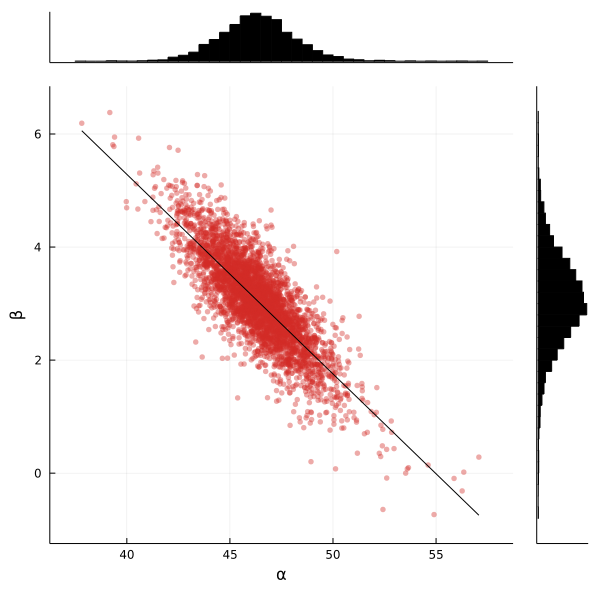

In [75]:
# Alt approach using corner
corner(chain, [:α, :β])

### Comparison to `lm()`

In [13]:
using GLM

In [14]:
results_lm = lm(@formula(vote ~ growth), hibbs)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

vote ~ 1 + growth

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  46.2476     1.62193   28.51    <1e-13   42.769     49.7263
growth        3.06053    0.696274   4.40    0.0006    1.56717    4.55389
────────────────────────────────────────────────────────────────────────